In [1]:
import iris
import xarray as xr
import pandas as pd
import glob
import os
import datetime
import glob
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import numpy as np
import cartopy.crs as ccrs

In [2]:
def crop_cube(cube1,cube2):
    lat_range = iris.Constraint(grid_latitude = lambda cell: cube2.coord("grid_latitude")[0].points <= cell <= cube2.coord("grid_latitude")[-1].points)
    lon_range = iris.Constraint(grid_longitude = lambda cell: cube2.coord("grid_longitude")[0].points <= cell <= cube2.coord("grid_longitude")[-1].points)
    cube1 = cube1.extract(lat_range)
    cube1 = cube1.extract(lon_range)
    return cube1

def crop_ds(ds1,ds2,data="fcst"):
    if data=="fcst":
        return ds1.sel(grid_latitude=slice(ds2.grid_latitude.min(),ds2.grid_latitude.max()),
                          grid_longitude=slice(ds2.grid_longitude.min(),ds2.grid_longitude.max()))
    if data=="rad":
        return ds1.sel(projection_x_coordinate=slice(ds2.projection_x_coordinate.min(),ds2.projection_x_coordinate.max()),
                       projection_y_coordinate=slice(ds2.projection_y_coordinate.min(),ds2.projection_y_coordinate.max()))


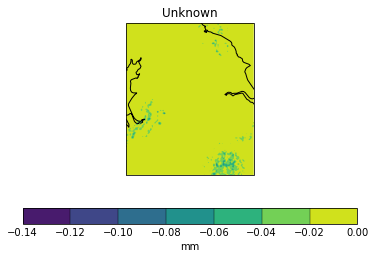

-0.125 0.008107290331342864


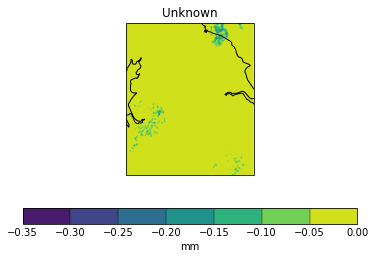

-0.34375 0.02120175613121715


In [3]:
new_cube=iris.load_cube("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_ens_pp_r30_t_60.nc")
old_cube_95=iris.load_cube("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_ens_perc_0.95_min_60_tot.nc")
old_cube_98=iris.load_cube("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_ens_perc_0.98_min_60_tot.nc")

old_cube_95=crop_cube(old_cube_95,new_cube)
old_cube_98=crop_cube(old_cube_98,new_cube)
new_cube_95=new_cube.extract(iris.Constraint(percentile=95))
new_cube_98=new_cube.extract(iris.Constraint(percentile=98))

diffs=old_cube_95-new_cube_95
contour = qplt.contourf(diffs)
plt.gca().coastlines()
plt.show()
print(diffs.data.min(),diffs.data.std())

diffs=old_cube_98-new_cube_98
contour = qplt.contourf(diffs)
plt.gca().coastlines()
plt.show()
print(diffs.data.min(),diffs.data.std())

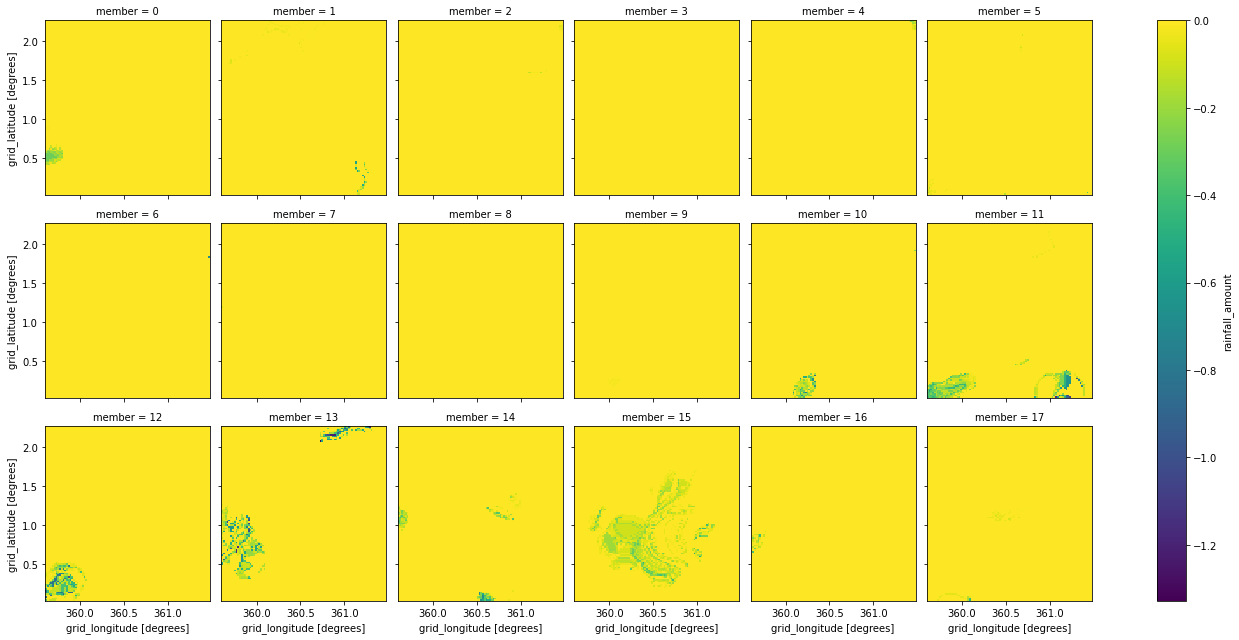

In [4]:
new_mem_ds=xr.open_dataset("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_mem_pp_r30_t_60.nc")
#new_mem_ds.rainfall_amount.sel(percentile=95).plot.pcolormesh(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

members=[]
for file in glob.glob("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_m??_perc_0.95_min_60_tot.nc"):
    file=xr.open_dataset(file)
    if len(file.coords) < 5:
        file=file.expand_dims(dim={"realization":1})
        file=file.assign_coords(realization=("realization", np.array([0])))
    members.append(file)
old_mem_ds=xr.concat(members,dim="realization")
old_mem_ds=old_mem_ds.rename({"realization":"member"})
old_mem_ds=old_mem_ds.assign_coords(member=("member", np.arange(0,18)))

old_mem_ds=old_mem_ds.sel(grid_latitude=slice(new_mem_ds.grid_latitude.min(),new_mem_ds.grid_latitude.max()),
                          grid_longitude=slice(new_mem_ds.grid_longitude.min(),new_mem_ds.grid_longitude.max()))
#old_mem_ds.rainfall_amount.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)
(old_mem_ds-new_mem_ds.sel(percentile=95)).rainfall_amount.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6)

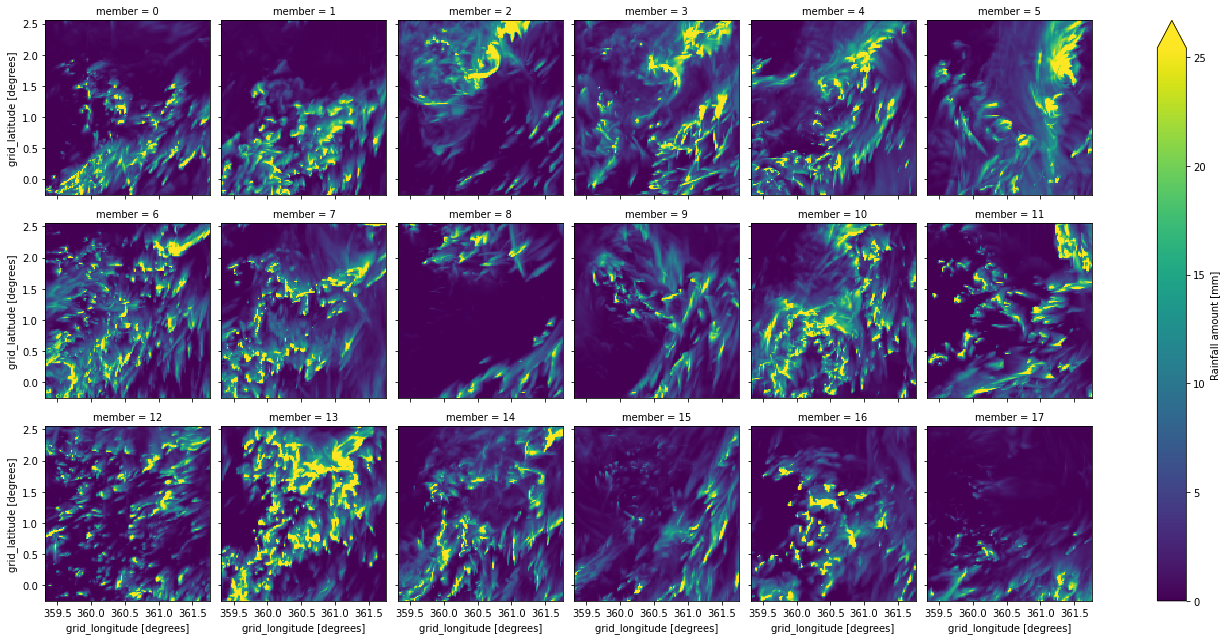

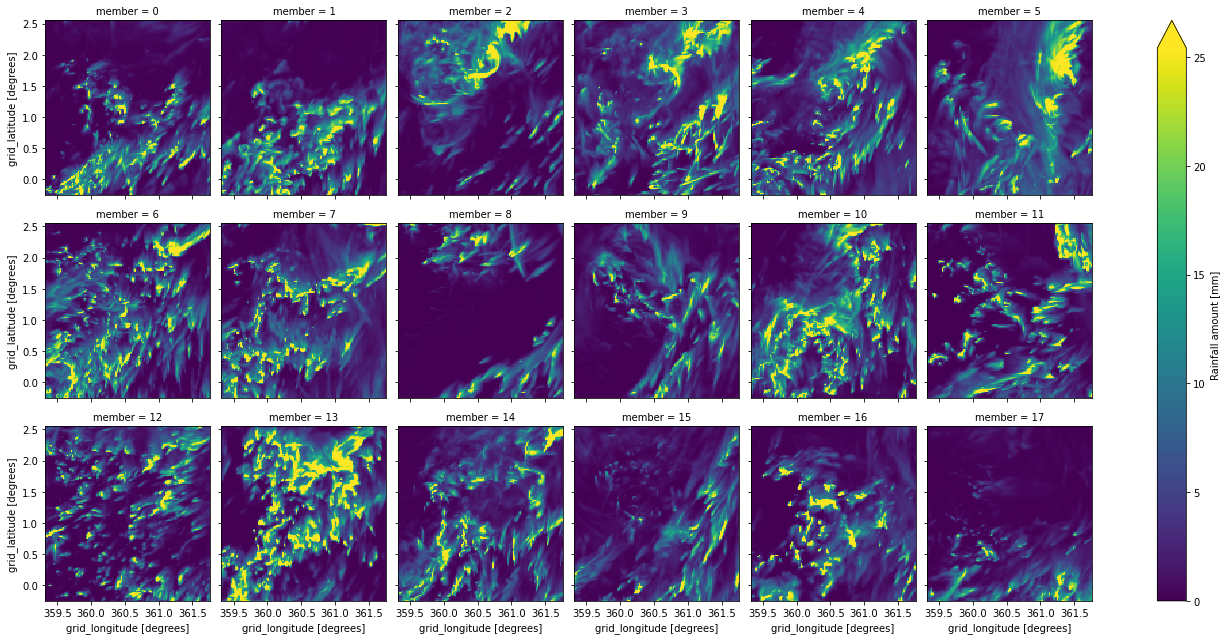

In [5]:
new_mem_ds=xr.open_dataset("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_max_rain_t_60.nc")
new_mem_ds.rainfall_amount.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

members=[]
for file in glob.glob("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_m??_exact_min_60.nc"):
    file=xr.open_dataset(file)
    if len(file.coords) < 5:
        file=file.expand_dims(dim={"realization":1})
        file=file.assign_coords(realization=("realization", np.array([0])))
    
    members.append(file)
old_mem_ds=xr.concat(members,dim="realization")
old_mem_ds=old_mem_ds.rename({"realization":"member"})
old_mem_ds=old_mem_ds.assign_coords(member=("member", np.arange(0,18)))

old_mem_ds=old_mem_ds.sel(grid_latitude=slice(new_mem_ds.grid_latitude.min(),new_mem_ds.grid_latitude.max()),
                          grid_longitude=slice(new_mem_ds.grid_longitude.min(),new_mem_ds.grid_longitude.max()))
old_mem_ds.rainfall_amount.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

<xarray.Dataset>
Dimensions:                     (realization: 18, grid_latitude: 140,
                                 grid_longitude: 122, bnds: 2)
Coordinates:
  * grid_latitude               (grid_latitude) float32 -0.2399 -0.2199 ... 2.54
  * grid_longitude              (grid_longitude) float32 359.3 359.4 ... 361.8
    forecast_period             (realization) timedelta64[ns] 1 days 06:57:29...
    time                        datetime64[ns] 2022-08-16T11:57:30.000000256
  * realization                 (realization) int64 0 1 2 3 4 ... 30 31 32 33 34
Dimensions without coordinates: bnds
Data variables:
    start_index                 (realization, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  (realization) int32 -2147483647 ... -2147483647
    forecast_period_bnds        (realization, bnds) float64 19.0 42.92 ... 43.92
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.9
    Conventions:  CF-1.5


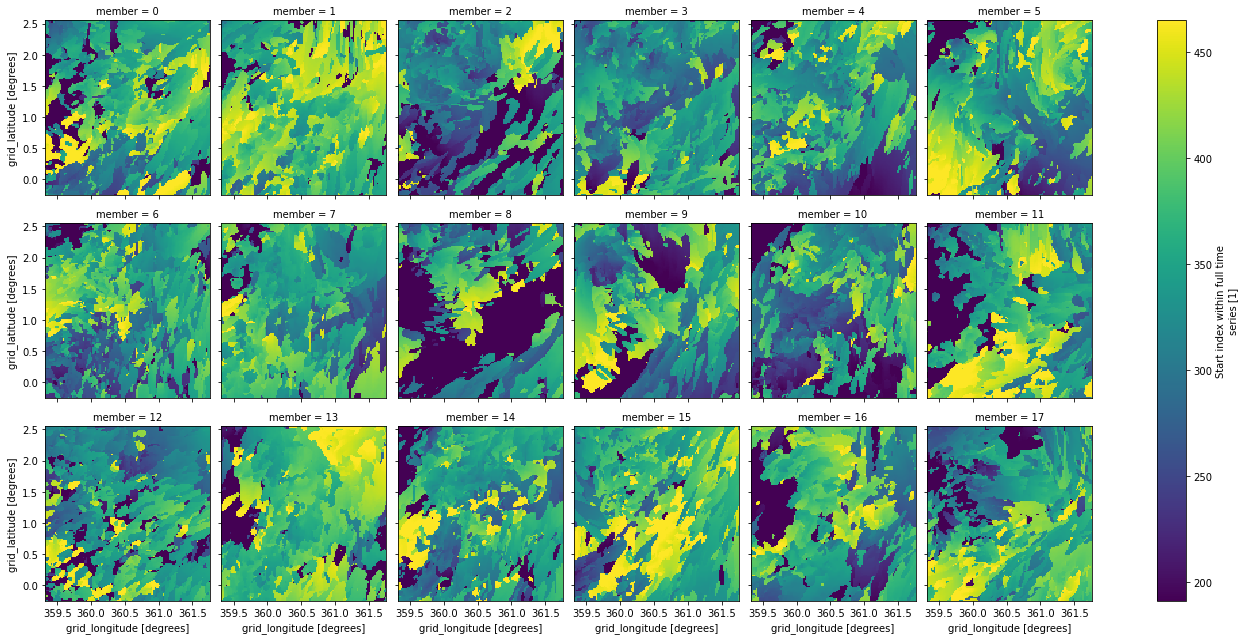

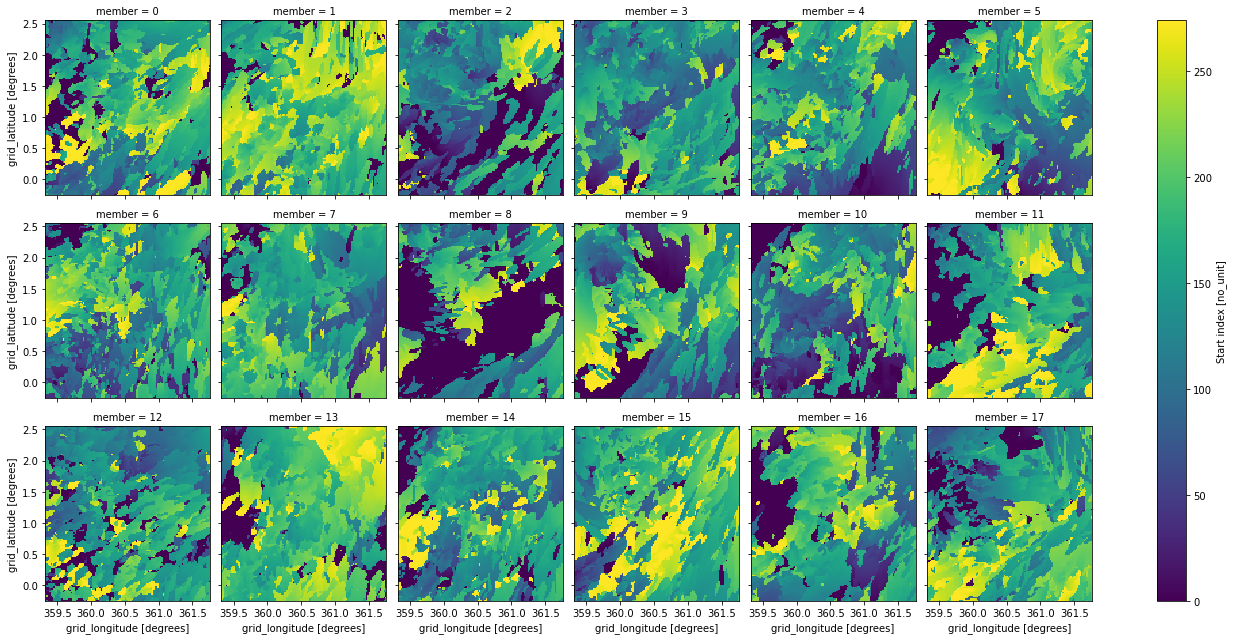

In [12]:
new_mem_time_ds=xr.open_dataset("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_exact_min_60_ind.nc")
new_mem_time_ds.start_index.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

members=[]
for file in glob.glob("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_m??_exact_min_60_ind.nc"):
    file=xr.open_dataset(file)
    if len(file.coords) < 5:
        file=file.expand_dims(dim={"realization":1})
        file=file.assign_coords(realization=("realization", np.array([0])))
    
    members.append(file)
old_mem_time_ds=xr.concat(members,dim="realization")
print(old_mem_time_ds)
old_mem_time_ds=old_mem_time_ds.rename({"realization":"member"})
old_mem_time_ds=old_mem_time_ds.assign_coords(member=("member", np.arange(0,18)))

old_mem_time_ds=old_mem_time_ds.sel(grid_latitude=slice(new_mem_ds.grid_latitude.min(),new_mem_ds.grid_latitude.max()),
                          grid_longitude=slice(new_mem_ds.grid_longitude.min(),new_mem_ds.grid_longitude.max()))
old_mem_time_ds.start_index.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

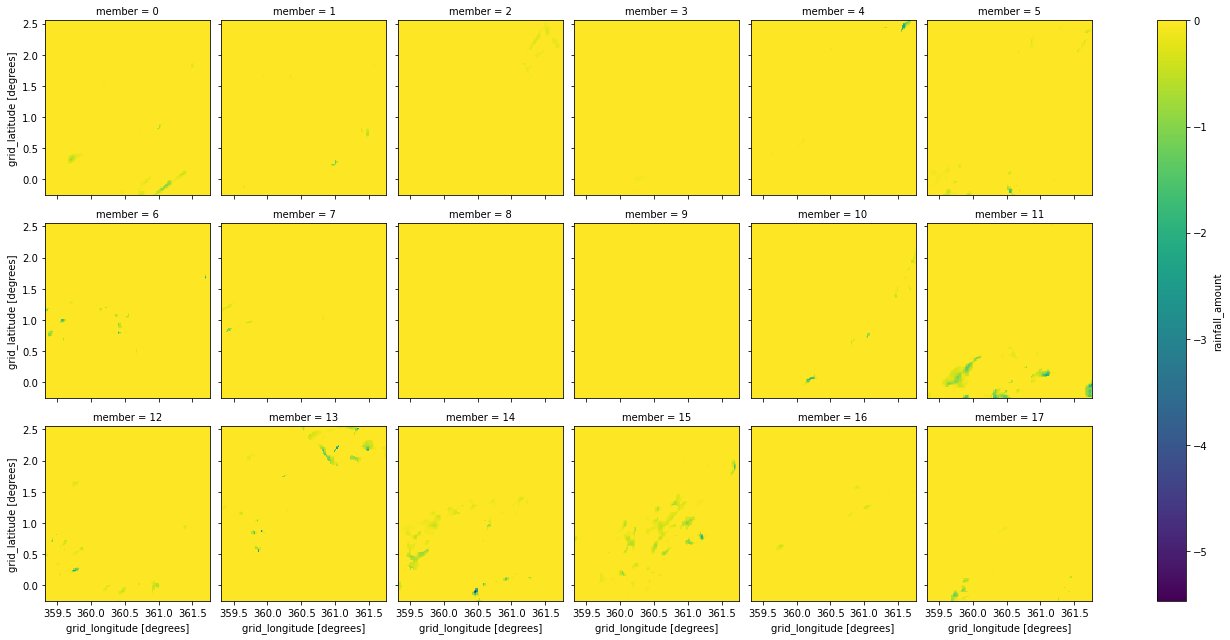

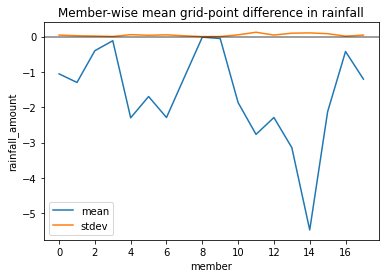

In [17]:
diffs=(old_mem_ds - new_mem_ds).rainfall_amount
#diffs=(old_mem_time_ds - (new_mem_time_ds-new_mem_time_ds.min())).start_index
diffs.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6)
plt.show()

diffs.min(dim=["grid_longitude","grid_latitude"]).plot(label="mean")
diffs.std(dim=["grid_longitude","grid_latitude"]).plot(label="stdev")
plt.xticks(np.arange(0,18,2))
plt.axhline(0,alpha=0.5,color="black")
plt.title("Member-wise mean grid-point difference in rainfall")
plt.legend()

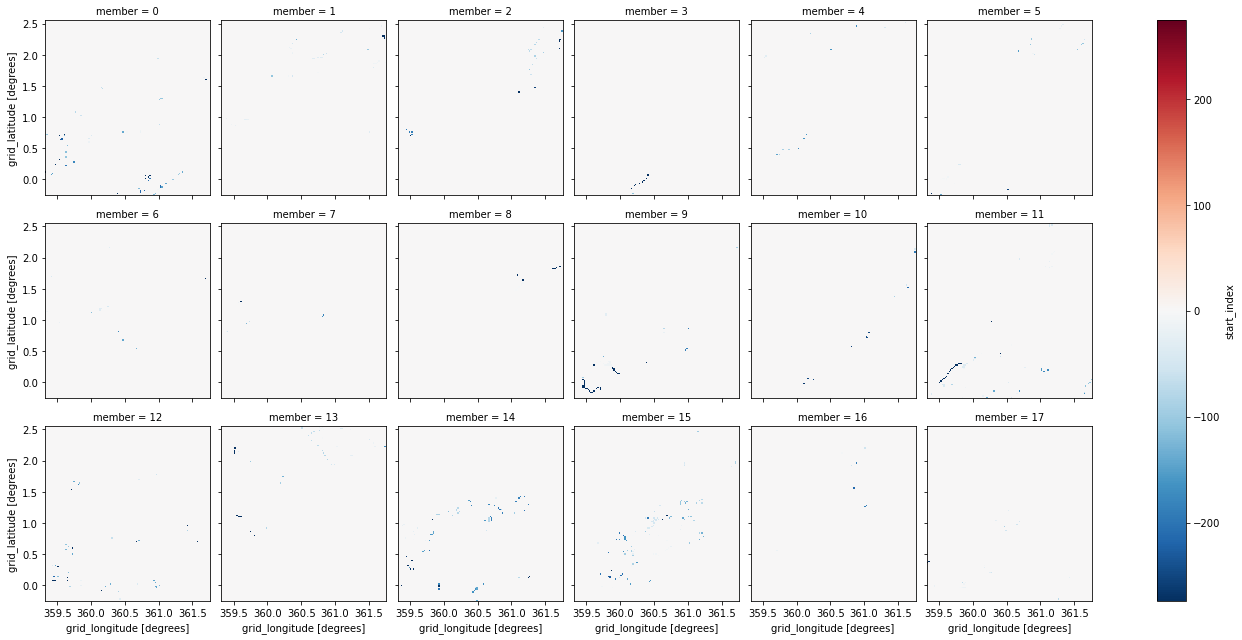

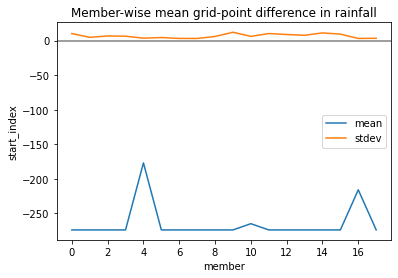

In [16]:
#diffs=(old_mem_ds - new_mem_ds).rainfall_amount
diffs=(old_mem_time_ds - (new_mem_time_ds-new_mem_time_ds.min())).start_index
diffs.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6)
plt.show()

diffs.min(dim=["grid_longitude","grid_latitude"]).plot(label="mean")
diffs.std(dim=["grid_longitude","grid_latitude"]).plot(label="stdev")
plt.xticks(np.arange(0,18,2))
plt.axhline(0,alpha=0.5,color="black")
plt.title("Member-wise mean grid-point difference in rainfall")
plt.legend()

In [7]:
new_rad_exact=xr.open_dataset("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_00/20220816_00_rad_exact_min_60.nc")
new_rad_pp=xr.open_dataset("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_00/20220816_00_rad_pp_r30_min_60_tot.nc")
old_rad_exact=xr.open_dataset("/gws/nopw/j04/icasp_swf/bmaybee/radar_obs/processed_radar/20220816_00/20220816_00_rad_exact_min_60.nc")
old_rad_pp=xr.open_dataset("/gws/nopw/j04/icasp_swf/bmaybee/radar_obs/processed_radar/20220816_00/20220816_00_rad_perc_0.95_min_60_tot.nc")

old_rad_exact=crop_ds(old_rad_exact,new_rad_exact,"rad")
old_rad_pp=crop_ds(old_rad_pp,new_rad_pp,"rad")

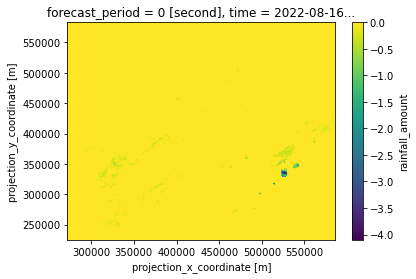

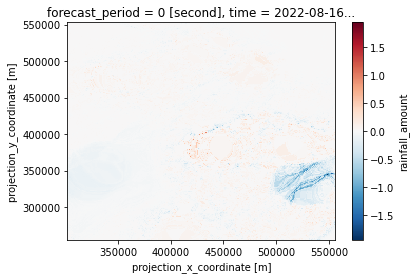

In [8]:
diffs_exact = (old_rad_exact - new_rad_exact)
diffs_exact.rainfall_amount.plot()
plt.show()
diffs_pp = (old_rad_pp - new_rad_pp.sel(percentile=95))
diffs_pp.rainfall_amount.plot()